### Imports

In [80]:
# Import coastline distance function from helper file
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [81]:
from calculate_distance_coastline import get_distance_to_coast_ddm
from calculate_ocean import is_ocean

In [82]:
data_path = Path("../data\processed\earthquake_data_tsunami_validated.csv")
data_df = pd.read_csv(data_path)

### Latitude and longitude were not meaningful earlier. We should create a meaningful location based feature.
This notebook begins by wiring in the coastline distance function so we can derive a new feature: the distance (in km) from each event to the nearest coastline. We’ll import the function from our helper module and get it ready for use in later steps.

In [83]:
# If the point is not in ocean, calculate distance to coastline
data_df["distance_to_coast_km"] = data_df.apply(lambda r: get_distance_to_coast_ddm(r["latitude"], r["longitude"]) if not is_ocean(r["latitude"], r["longitude"]) else 0, axis=1)
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,distance_to_coast_km
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,0,0.0
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0,0.0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,0,0.0
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,0,0.0
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,0,0.0


### Now we can explore this feature further.

In [84]:
mean_distance = data_df.groupby("tsunami")["distance_to_coast_km"].mean()
print(mean_distance.values)


[106.62364588   8.26517428]


### Mean values show significant difference between classes.

In [85]:
# correlation between distance to coast and tsunami occurrence
print(data_df.corr()["tsunami"]["distance_to_coast_km"])

-0.13999074026198058


### As expected there is a meaningful negative correlation.

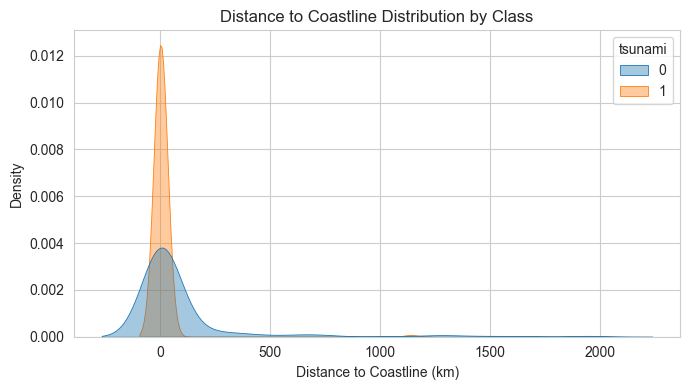

In [86]:
fig, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(
    data=data_df,
    x="distance_to_coast_km",
    hue="tsunami",
    common_norm=False,
    fill=True,
    alpha=0.4,
    linewidth=0.6,
    ax=ax
)
ax.set_title("Distance to Coastline Distribution by Class")
ax.set_xlabel("Distance to Coastline (km)")

plt.tight_layout()
plt.show()

This plot shows that the tsunamis happen where distance to coastline is low. Now we can remove 'latitude' and 'longitude' columns from our data

In [87]:
data_df = data_df.drop(columns=["latitude", "longitude"])

### Using the time features.
In the current data, the 'Year' and 'Month' columns are not a good identifier for detecting tsunamis. Thus we will try to create better time features. Since earthquakes can trigger other earthquakes in a linear time-line, we can create a new column called 'month_number'.

In [88]:
if ("Year" not in data_df.columns) or ("Month" not in data_df.columns):
    dt_col = next((c for c in ["time","date","datetime"] if c in data_df.columns), None)
    dt = pd.to_datetime(data_df[dt_col], errors="coerce")
    data_df["Year"] = dt.dt.year
    data_df["Month"] = dt.dt.month

data_df["month_number"] = (data_df["Year"] - 2000) * 12 + data_df["Month"]

print(data_df[["Year","Month","month_number"]].head())

   Year  Month  month_number
0  2022     11           275
1  2022     11           275
2  2022     11           275
3  2022     11           275
4  2022     11           275


In [89]:
# Check correlation of month_number with tsunami
work_df = data_df[["month_number", "Year", "Month", "tsunami"]].dropna().copy()
work_df["tsunami"] = work_df["tsunami"].astype(int)
corr_month_number = work_df[["month_number", "tsunami"]].corr().iloc[0,1]
print(f"Correlation month_number-tsunami: {corr_month_number:.4f}")

Correlation month_number-tsunami: -0.0943


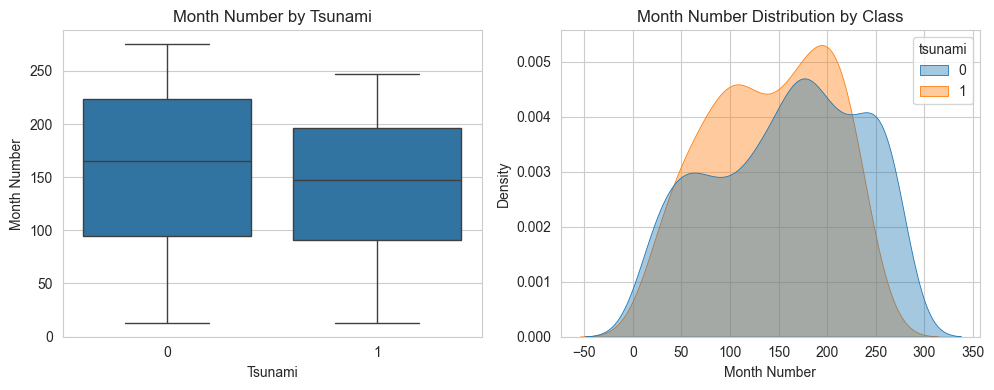

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(data=data_df, x='tsunami', y='month_number', ax=ax[0])
ax[0].set_title('Month Number by Tsunami'); ax[0].set_xlabel('Tsunami'); ax[0].set_ylabel('Month Number')

sns.kdeplot(data=data_df, x='month_number', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6, ax=ax[1])
ax[1].set_title('Month Number Distribution by Class'); ax[1].set_xlabel('Month Number')

plt.tight_layout()
plt.show()

Still there is no meaningful insight using time features. Time is redundant for determining the tsunamis. So we can remove the time features from our data.

In [91]:
data_df = data_df.drop(columns=["Year", "Month","month_number"])
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,tsunami,distance_to_coast_km
0,7.0,8,7,768,117,0.509,17.0,14.000,0,0.0
1,6.9,4,4,735,99,2.229,34.0,25.000,0,0.0
2,7.0,3,3,755,147,3.125,18.0,579.000,0,0.0
3,7.3,5,5,833,149,1.865,21.0,37.000,0,0.0
4,6.6,0,2,670,131,4.998,27.0,624.464,0,0.0


### In EDA we have observed that dmin and nst features were not properly set.
Since half ot the data points that belongs to nst and dmin are not set correctly, we have to drop those columns.

In [92]:
data_df = data_df.drop(columns=["dmin", "nst"])
data_df.head()

,magnitude,cdi,mmi,sig,gap,depth,tsunami,distance_to_coast_km
0,7.0,8,7,768,17.0,14.000,0,0.0
1,6.9,4,4,735,34.0,25.000,0,0.0
2,7.0,3,3,755,18.0,579.000,0,0.0
3,7.3,5,5,833,21.0,37.000,0,0.0
4,6.6,0,2,670,27.0,624.464,0,0.0
